# adapters中的代码

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import math
from collections import defaultdict
from typing import Any, BinaryIO, IO, Iterable
from torch import Tensor
import regex as re
import numpy
import torch
import torch.nn.functional as F
from torch.nn.utils.clip_grad import clip_grad_norm_


# 交叉熵损失

In [ ]:
# 交叉熵损失函数实现
def run_cross_entropy(
    inputs: Tensor, targets: Tensor
) -> Tensor:
    """Given a tensor of inputs and targets, compute the average cross-entropy
    loss across examples.

    Args:
        inputs (Float[Tensor, "batch_size vocab_size"]): inputs[i][j] is the
            unnormalized logit of jth class for the ith example.
        targets (Int[Tensor, "batch_size"]): Tensor of shape (batch_size,) with the index of the correct class.
            Each value must be between 0 and `num_classes - 1`.

    Returns:
        Float[Tensor, ""]: The average cross-entropy loss across examples.
    """
    # 数值稳定性处理：减去最大值
    max_vals = torch.max(inputs, dim=1, keepdim=True)[0]
    shifted_logits = inputs - max_vals
    
    # 计算log softmax
    log_sum_exp = torch.log(torch.sum(torch.exp(shifted_logits), dim=1, keepdim=True))
    log_probs = shifted_logits - log_sum_exp
    
    # 获取目标token的log概率
    batch_size = inputs.shape[0]
    target_log_probs = log_probs[torch.arange(batch_size), targets]
    
    # 计算负对数似然损失
    loss = -torch.mean(target_log_probs)
    
    return loss


## 正确性对比  
自己实现+torch官方实现  
## 数值稳定性测试  
把同样的 logits 放大 1000 倍（远远超出 float32 的 exp 上限），再重复第 1 步比对。  
如果 你的实现 在超大数值下仍然跟官方误差 <1e-4，说明你做了 数值稳定技巧（常用的是 log-sum-exp 技巧或直接使用 PyTorch 自带的稳定路径），而不是直接写  
−log(exp(x[y]) / Σexp(x)) 这种会爆 inf 的朴素公式。

In [5]:

inputs = torch.tensor(
    [
        [
            [0.1088, 0.1060, 0.6683, 0.5131, 0.0645],
            [0.4538, 0.6852, 0.2520, 0.3792, 0.2675],
            [0.4578, 0.3357, 0.6384, 0.0481, 0.5612],
            [0.9639, 0.8864, 0.1585, 0.3038, 0.0350],
        ],
        [
            [0.3356, 0.9013, 0.7052, 0.8294, 0.8334],
            [0.6333, 0.4434, 0.1428, 0.5739, 0.3810],
            [0.9476, 0.5917, 0.7037, 0.2987, 0.6208],
            [0.8541, 0.1803, 0.2054, 0.4775, 0.8199],
        ],
    ]
)
targets = torch.tensor([[1, 0, 2, 2], [4, 1, 4, 0]])
expected = F.cross_entropy(inputs.view(-1, inputs.size(-1)), targets.view(-1))
numpy.testing.assert_allclose(
    run_cross_entropy(inputs.view(-1, inputs.size(-1)), targets.view(-1)).detach().numpy(),
    expected.detach().numpy(),
    atol=1e-4,
)
# Test that cross-entropy handles numerical overflow issues
large_inputs = 1000.0 * inputs
large_expected_cross_entropy = F.cross_entropy(large_inputs.view(-1, large_inputs.size(-1)), targets.view(-1))
numpy.testing.assert_allclose(
    run_cross_entropy(large_inputs.view(-1, large_inputs.size(-1)), targets.view(-1)).detach().numpy(),
    large_expected_cross_entropy.detach().numpy(),
    atol=1e-4,
)

In [7]:
# 梯度裁剪实现
def run_gradient_clipping(parameters: Iterable[torch.nn.Parameter], max_l2_norm: float) -> None:
    """Given a set of parameters, clip their combined gradients to have l2 norm at most max_l2_norm.

    Args:
        parameters (Iterable[torch.nn.Parameter]): collection of trainable parameters.
        max_l2_norm (float): a positive value containing the maximum l2-norm.

    The gradients of the parameters (parameter.grad) should be modified in-place.
    """
    parameters = [p for p in parameters if p.grad is not None]
    
    if len(parameters) == 0:
        return
    
    # 计算所有梯度的L2范数
    total_norm = 0.0
    for p in parameters:
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    
    # 计算裁剪系数
    clip_coef = max_l2_norm / (total_norm + 1e-6)
    
    # 如果总范数超过最大值，则裁剪梯度
    if clip_coef < 1.0:
        for p in parameters:
            p.grad.data.mul_(clip_coef)


把「你的梯度裁剪实现」和 PyTorch 官方 torch.nn.utils.clip_grad_norm_ 放在完全相同的梯度场上，逐元素比较结果，误差在 1e-6 以内即视为通过。

1. 准备相同“梯度场”  
用同一组随机张量做两份 独立拷贝（t1 vs t1_c）。   
都把最后一个参数设为 requires_grad=False（模拟冻结），保证二者 可训练参数集合完全一致。  
各自前向：把全部参数展平后求和 → 反向得到 原始梯度。  
此时两份梯度在数值上 逐比特相同。   
2. 分别做裁剪  
t1 用 官方 clip_grad_norm_(t1, max_norm)  
t1_c 用 你的 run_gradient_clipping(t1_c, max_norm)  
3. 结果比对  
把两份梯度取出来（冻结的跳过），逐元素 assert_allclose，atol=1e-6。  
只要你的 total_norm 计算、裁剪系数、in-place 乘法与官方完全一致，就能通过。  

In [21]:
def test_gradient_clipping():
    tensors = [torch.randn((5, 5)) for _ in range(6)]
    max_norm = 1e-2

    t1 = tuple(torch.nn.Parameter(torch.clone(t)) for t in tensors)
    # Test freezing one parameter.
    t1[-1].requires_grad_(False)

    loss = torch.cat(t1).sum()
    loss.backward()
    clip_grad_norm_(t1, max_norm)
    t1_grads = [torch.clone(t.grad) for t in t1 if t.grad is not None]

    t1_c = tuple(torch.nn.Parameter(torch.clone(t)) for t in tensors)
    t1_c[-1].requires_grad_(False)
    loss_c = torch.cat(t1_c).sum()
    loss_c.backward()
    run_gradient_clipping(t1_c, max_norm)
    t1_c_grads = [torch.clone(t.grad) for t in t1_c if t.grad is not None]

    assert len(t1_grads) == len(t1_c_grads)

    for t1_grad, t1_c_grad in zip(t1_grads, t1_c_grads):
        numpy.testing.assert_allclose(
            t1_grad.detach().numpy(),
            t1_c_grad.detach().numpy(),
            atol=1e-6,
        )

if __name__ == "__main__":
    test_gradient_clipping()

# 随机梯度下降（SGD）

In [31]:
from collections.abc import Callable, Iterable
from typing import Optional
import torch
import math
class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {"lr": lr}
        super().__init__(params, defaults)
    def step(self, closure: Optional[Callable] = None):
        loss = None if closure is None else closure()
        for group in self.param_groups:
            lr = group["lr"] # Get the learning rate.

            for p in group["params"]:
                if p.grad is None:
                    continue
                state = self.state[p] # Get state associated with p.
                t = state.get("t", 0) # Get iteration number from the state, or initial value.
                grad = p.grad.data # Get the gradient of loss with respect to p.
                p.data -= lr / math.sqrt(t + 1) * grad # Update weight tensor in-place.
                state["t"] = t + 1 # Increment iteration number.
        return loss

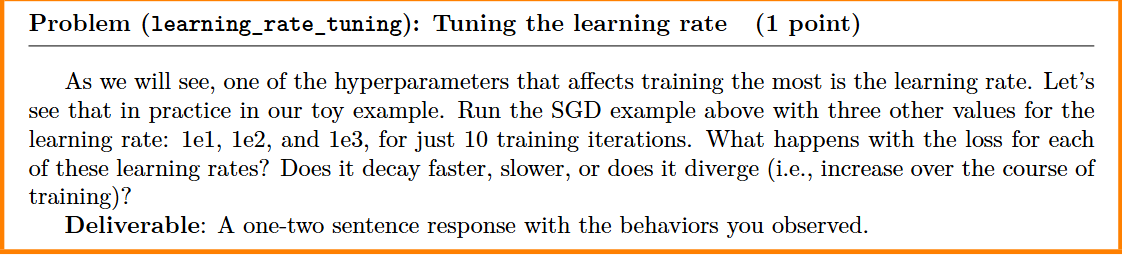

In [10]:
# lr_tuning_demo.py
import torch
import torch.nn as nn

# 固定随机种子，保证三次实验初始状态完全一致
torch.manual_seed(0)

# 随便造一个微型 MSE 任务：把常数 1 映射到常数 -1
model = nn.Linear(1, 1)
criterion = nn.MSELoss()
X = torch.ones((32, 1))      # 32 个样本，特征=1
Y = -1.0 * torch.ones(32)    # 标签=-1

def train_and_log(lr, iters=10):
    print(f"\n----- LR = {lr} -----")
    # 重新初始化权重，保证起点一样
    torch.manual_seed(0)
    model.reset_parameters()
    optimizer = SGD(model.parameters(), lr=lr)
    
    for i in range(1, iters + 1):
        optimizer.zero_grad()
        out = model(X).squeeze()
        loss = criterion(out, Y)
        loss.backward()
        optimizer.step()
        print(f"iter {i:2d}: loss = {loss.item():.4f}")

if __name__ == "__main__":
    for lr in [1e-1, 1e-2, 1e-3]:
        train_and_log(lr)


----- LR = 0.1 -----
iter  1: loss = 2.3377
iter  2: loss = 0.8416
iter  3: loss = 0.4328
iter  4: loss = 0.2560
iter  5: loss = 0.1638
iter  6: loss = 0.1105
iter  7: loss = 0.0773
iter  8: loss = 0.0557
iter  9: loss = 0.0411
iter 10: loss = 0.0309

----- LR = 0.01 -----
iter  1: loss = 2.3377
iter  2: loss = 2.1544
iter  3: loss = 2.0343
iter  4: loss = 1.9414
iter  5: loss = 1.8645
iter  6: loss = 1.7984
iter  7: loss = 1.7402
iter  8: loss = 1.6879
iter  9: loss = 1.6405
iter 10: loss = 1.5971

----- LR = 0.001 -----
iter  1: loss = 2.3377
iter  2: loss = 2.3190
iter  3: loss = 2.3059
iter  4: loss = 2.2953
iter  5: loss = 2.2861
iter  6: loss = 2.2780
iter  7: loss = 2.2705
iter  8: loss = 2.2637
iter  9: loss = 2.2573
iter 10: loss = 2.2513


### lr=0.1 损失迅速衰减；lr=0.01 衰减缓慢；lr=0.001 几乎原地踏步，但三者均未发散

# AdamW优化器

In [11]:
# AdamW优化器实现
class AdamW(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, 
                 weight_decay=0.01, correct_bias=True):
        if lr < 0.0:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super().__init__(params, defaults)
    
    def step(self, closure=None):
        """Performs a single optimization step."""
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdamW does not support sparse gradients')
                
                state = self.state[p]
                
                # 初始化状态
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                
                state['step'] += 1
                
                # 更新一阶和二阶矩估计
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                
                # 偏差校正
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                step_size = group['lr']
                if group['correct_bias']:
                    step_size = step_size * math.sqrt(bias_correction2) / bias_correction1
                
                # Adam更新
                denom = exp_avg_sq.sqrt().add_(group['eps'])
                p.data.addcdiv_(exp_avg, denom, value=-step_size)
                
                # 权重衰减（解耦）
                if group['weight_decay'] != 0:
                    p.data.add_(p.data, alpha=-group['lr'] * group['weight_decay'])
        
        return loss

# 获取AdamW优化器类
def get_adamw_cls() -> Any:
    """
    Returns a torch.optim.Optimizer that implements AdamW.
    """
    return AdamW


“只要你的 AdamW 实现跟 PyTorch 官方足够接近（atol=1e-4），就直接放行；否则再跟你自己的快照（snapshot）比对，快照不匹配就报错。”  
测试逻辑：  
先跑官方 PyTorch AdamW 得到一组权重作为“金标准”，再跑你的实现 get_adamw_cls() 得到另一组权重；  
若两者在 1e-4 误差内重合 → 测试通过；  
不重合 → 用 numpy_snapshot 把你现在的权重存成基准，下次跑时若偏离这个基准就失败。  

In [32]:
def _optimize(opt_class) -> torch.Tensor:
    torch.manual_seed(42)
    model = torch.nn.Linear(3, 2, bias=False)
    opt = opt_class(
        model.parameters(),
        lr=1e-3,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8,
    )
    # Use 1000 optimization steps for testing
    for _ in range(1000):
        opt.zero_grad()
        x = torch.rand(model.in_features)
        y_hat = model(x)
        y = torch.tensor([x[0] + x[1], -x[2]])
        loss = ((y - y_hat) ** 2).sum()
        loss.backward()
        opt.step()
    return model.weight.detach()

def test_adamw(numpy_snapshot):
    """
    Our reference implementation yields slightly different results than the
    PyTorch AdamW, since there are a couple different ways that you can apply
    weight decay that are equivalent in principle, but differ in practice due to
    floating point behavior. So, we test that the provided implementation matches
    _either_ our reference implementation's expected results or those from the PyTorch AdamW.
    """
    # expected_weights = torch.load(FIXTURES_PATH / "adamw_expected_params.pt")
    pytorch_weights = _optimize(torch.optim.AdamW)
    actual_weights = _optimize(get_adamw_cls())
    # Might need to exit early if the weights match pytorch, since that should also be valid
    matches_pytorch = torch.allclose(actual_weights, pytorch_weights, atol=1e-4)
    if matches_pytorch:
        print("合格")
        print("AdamW implementation matches PyTorch AdamW.")
        return
    numpy_snapshot.assert_match(
        actual_weights,
        atol=1e-4,
    )

if __name__ == "__main__":
    test_adamw(numpy)

合格
AdamW implementation matches PyTorch AdamW.


In [18]:

def run_get_lr_cosine_schedule(
    it: int,
    max_learning_rate: float,
    min_learning_rate: float,
    warmup_iters: int,
    cosine_cycle_iters: int,
):
    """
    Given the parameters of a cosine learning rate decay schedule (with linear
    warmup) and an iteration number, return the learning rate at the given
    iteration under the specified schedule.

    Args:
        it (int): Iteration number to get learning rate for.
        max_learning_rate (float): alpha_max, the maximum learning rate for
            cosine learning rate schedule (with warmup).
        min_learning_rate (float): alpha_min, the minimum / final learning rate for
            the cosine learning rate schedule (with warmup).
        warmup_iters (int): T_w, the number of iterations to linearly warm-up
            the learning rate.
        cosine_cycle_iters (int): T_c, the number of cosine annealing iterations.

    Returns:
        Learning rate at the given iteration under the specified schedule.
    """
    if it < warmup_iters:
        # 预热阶段：从0线性增加到max_learning_rate
        return max_learning_rate * (it / warmup_iters)
    elif it <= cosine_cycle_iters:
        # 余弦退火阶段：从max_learning_rate衰减到min_learning_rate
        progress = (it - warmup_iters) / (cosine_cycle_iters - warmup_iters)
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
        return min_learning_rate + (max_learning_rate - min_learning_rate) * cosine_decay
    else:
        # 退火后阶段：保持最小学习率
        return min_learning_rate

“把你实现的 cosine+warmup 调度函数，与一份手工算好的‘标准曲线’逐点比对，误差不超过默认容差（≈1e-7）就算通过。”  
逐句拆解：  
给定超参  
peak=1.0，final=0.1，warm-up 7 步，余弦退火到第 21 步，之后恒定为 0.1。  
期望数组 expected_lrs 已按同样规则提前算好 25 个点：  
0-6 步线性爬升；  
7-21 步单周期余弦降到 0.1；  
22-24 步保持 0.1。  
循环调用你的 run_get_lr_cosine_schedule 生成实际曲线，与期望数组 assert_allclose。  
若所有点差异 <1e-6 级 → 测试静默通过；有任何点超出 → 抛 AssertionError 并打印具体索引和差值。  
一句话总结：  
这就是“快照回归测试”，确保你的 cosine+warmup 实现与基准曲线逐比特一致，防止后续改代码时无意改错公式。  

In [19]:
def test_get_lr_cosine_schedule():
    max_learning_rate = 1
    min_learning_rate = 1 * 0.1
    warmup_iters = 7
    cosine_cycle_iters = 21

    expected_lrs = [
        0,
        0.14285714285714285,
        0.2857142857142857,
        0.42857142857142855,
        0.5714285714285714,
        0.7142857142857143,
        0.8571428571428571,
        1.0,
        0.9887175604818206,
        0.9554359905560885,
        0.9018241671106134,
        0.8305704108364301,
        0.7452476826029011,
        0.6501344202803414,
        0.55,
        0.44986557971965857,
        0.3547523173970989,
        0.26942958916356996,
        0.19817583288938662,
        0.14456400944391146,
        0.11128243951817937,
        0.1,
        0.1,
        0.1,
        0.1,
    ]
    actual_lrs = [
        run_get_lr_cosine_schedule(
            it=it,
            max_learning_rate=max_learning_rate,
            min_learning_rate=min_learning_rate,
            warmup_iters=warmup_iters,
            cosine_cycle_iters=cosine_cycle_iters,
        )
        for it in range(25)
    ]
    numpy.testing.assert_allclose(numpy.array(actual_lrs), numpy.array(expected_lrs))

if __name__ == "__main__":
    test_get_lr_cosine_schedule()

In [28]:

# 检查点保存和加载实现
def run_save_checkpoint(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    iteration: int,
    out: str | os.PathLike | BinaryIO | IO[bytes],
):
    """
    Given a model, optimizer, and an iteration number, serialize them to disk.

    Args:
        model (torch.nn.Module): Serialize the state of this model.
        optimizer (torch.optim.Optimizer): Serialize the state of this optimizer.
        iteration (int): Serialize this value, which represents the number of training iterations
            we've completed.
        out (str | os.PathLike | BinaryIO | IO[bytes]): Path or file-like object to serialize the model, optimizer, and iteration to.
    """
    checkpoint = {
        'iteration': iteration,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, out)


In [29]:

# 检查点加载实现
def run_load_checkpoint(
    src: str | os.PathLike | BinaryIO | IO[bytes],
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
) -> int:
    """
    Given a serialized checkpoint (path or file-like object), restore the
    serialized state to the given model and optimizer.
    Return the number of iterations that we previously serialized in
    the checkpoint.

    Args:
        src (str | os.PathLike | BinaryIO | IO[bytes]): Path or file-like object to serialized checkpoint.
        model (torch.nn.Module): Restore the state of this model.
        optimizer (torch.optim.Optimizer): Restore the state of this optimizer.
    Returns:
        int: the previously-serialized number of iterations.
    """
    checkpoint = torch.load(src, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['iteration']


“把模型+优化器训练几步后存盘，再从磁盘原样读回来，比较权重和优化器状态是否逐比特一致；一致就说明 checkpoint 读写功能正确。”
逐句拆解：  
训练 10 步  
固定随机种子，保证每次初始权重、数据、梯度都一样。  
run_save_checkpoint(...)  
把当前 模型参数、优化器状态、迭代次数 一次性写到 tmp_path/checkpoint.pt。  
新建另一组 空模型+空优化器  
结构与超参完全相同，但参数是重新初始化的，和原模型不同。  
run_load_checkpoint(...)  
从刚才的文件恢复，in-place 覆盖新模型和新优化器的内部状态，并返回 recorded iteration。  
层层比对  
迭代次数相等；  
模型 state_dict 所有键、张量逐元素 <1e-8 级误差；  
优化器 state_dict 用 are_optimizers_equal 递归检查：键集合相同、超参相同、所有张量 torch.allclose 通过。  
全部通过 → checkpoint 序列化/反序列化无丢失，测试静默成功；  
任何一项不符 → 抛 AssertionError，提示 checkpoint 实现有 bug。  
一句话总结：  
这就是“ checkpoint 回归测试”——练几步→存档→读档→逐比特核对，确保存盘/加载不会丢状态或改数值。  

In [30]:
#测试网络定义
class _TestNet(nn.Module):
    def __init__(self, d_input: int = 100, d_output: int = 10):
        super().__init__()
        self.fc1 = nn.Linear(d_input, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, d_output)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# 优化器状态比较函数
def are_optimizers_equal(optimizer1_state_dict, optimizer2_state_dict, atol=1e-8, rtol=1e-5):
    # Check if the keys of the main dictionaries are equal (e.g., 'state', 'param_groups')
    if set(optimizer1_state_dict.keys()) != set(optimizer2_state_dict.keys()):
        return False

    # Check parameter groups are identical
    if optimizer1_state_dict["param_groups"] != optimizer2_state_dict["param_groups"]:
        return False

    # Check states
    state1 = optimizer1_state_dict["state"]
    state2 = optimizer2_state_dict["state"]
    if set(state1.keys()) != set(state2.keys()):
        return False

    for key in state1:
        # Assuming state contents are also dictionaries
        if set(state1[key].keys()) != set(state2[key].keys()):
            return False

        for sub_key in state1[key]:
            item1 = state1[key][sub_key]
            item2 = state2[key][sub_key]

            # If both items are tensors, use torch.allclose
            if torch.is_tensor(item1) and torch.is_tensor(item2):
                if not torch.allclose(item1, item2, atol=atol, rtol=rtol):
                    return False
            # For non-tensor items, check for direct equality
            elif item1 != item2:
                return False
    return True

def test_checkpointing(tmp_path):
    torch.manual_seed(42)
    d_input = 100
    d_output = 10
    num_iters = 10

    model = _TestNet(d_input=d_input, d_output=d_output)
    optimizer = get_adamw_cls()(
        model.parameters(),
        lr=1e-3,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8,
    )
    # Use 1000 optimization steps for testing
    it = 0
    for _ in range(num_iters):
        optimizer.zero_grad()
        x = torch.rand(d_input)
        y = torch.rand(d_output)
        y_hat = model(x)
        loss = ((y - y_hat) ** 2).sum()
        loss.backward()
        optimizer.step()
        it += 1

    serialization_path = tmp_path / "checkpoint.pt"
    # Save the model
    run_save_checkpoint(
        model,
        optimizer,
        iteration=it,
        out=serialization_path,
    )

    # Load the model back again
    new_model = _TestNet(d_input=d_input, d_output=d_output)
    new_optimizer = get_adamw_cls()(
        new_model.parameters(),
        lr=1e-3,
        weight_decay=0.01,
        betas=(0.9, 0.999),
        eps=1e-8,
    )
    loaded_iterations = run_load_checkpoint(src=serialization_path, model=new_model, optimizer=new_optimizer)
    assert it == loaded_iterations

    # Compare the loaded model state with the original model state
    original_model_state = model.state_dict()
    original_optimizer_state = optimizer.state_dict()
    new_model_state = new_model.state_dict()
    new_optimizer_state = new_optimizer.state_dict()

    # Check that state dict keys match
    assert set(original_model_state.keys()) == set(new_model_state.keys())
    assert set(original_optimizer_state.keys()) == set(new_optimizer_state.keys())

    # compare the model state dicts
    for key in original_model_state.keys():
        numpy.testing.assert_allclose(
            original_model_state[key].detach().numpy(),
            new_model_state[key].detach().numpy(),
        )
    # compare the optimizer state dicts
    assert are_optimizers_equal(original_optimizer_state, new_optimizer_state)

if __name__ == "__main__":
    import tempfile, pathlib
    with tempfile.TemporaryDirectory() as tmpdirname:
        test_checkpointing(pathlib.Path(tmpdirname))

In [ ]:

class Tokenizer:
    def __init__(self, vocab: dict[int, bytes], merges: list[tuple[bytes, bytes]], special_tokens: list[str] | None = None):
        self.vocab = vocab.copy()
        self.merges = merges.copy()
        self.special_tokens = special_tokens or []
        
        # 创建反向词汇表
        self.inverse_vocab = {token_bytes: token_id for token_id, token_bytes in self.vocab.items()}
        
        # 添加特殊token到词汇表
        max_id = max(self.vocab.keys()) if self.vocab else -1
        for special_token in self.special_tokens:
            special_bytes = special_token.encode('utf-8')
            if special_bytes not in self.inverse_vocab:
                max_id += 1
                self.vocab[max_id] = special_bytes
                self.inverse_vocab[special_bytes] = max_id
        
        # 预编译GPT-2的正则表达式模式
        self.pattern = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
    
    @classmethod
    def from_files(cls, vocab_filepath: str, merges_filepath: str, special_tokens: list[str] | None = None):
        # 这里需要根据实际的文件格式实现加载逻辑
        # 假设vocab和merges以某种格式保存
        raise NotImplementedError("需要根据实际文件格式实现")
    
    def encode(self, text: str) -> list[int]:
        """Encode text to token IDs."""
        # 处理特殊token
        if self.special_tokens:
            # 简单的特殊token处理：先分割特殊token
            parts = [text]
            for special_token in self.special_tokens:
                new_parts = []
                for part in parts:
                    if special_token in part:
                        split_parts = part.split(special_token)
                        for i, split_part in enumerate(split_parts):
                            if split_part:
                                new_parts.append(split_part)
                            if i < len(split_parts) - 1:
                                new_parts.append(special_token)
                    else:
                        new_parts.append(part)
                parts = new_parts
        else:
            parts = [text]
        
        # 编码每个部分
        token_ids = []
        for part in parts:
            if part in self.special_tokens:
                # 特殊token直接编码
                special_bytes = part.encode('utf-8')
                token_ids.append(self.inverse_vocab[special_bytes])
            else:
                # 普通文本使用BPE编码
                token_ids.extend(self._encode_text(part))
        
        return token_ids
    
    def _encode_text(self, text: str) -> list[int]:
        """Encode regular text using BPE."""
        # 预分词
        pretokens = re.findall(self.pattern, text)
        
        token_ids = []
        for pretoken in pretokens:
            # 将预分词转换为字节序列
            current_bytes = pretoken.encode('utf-8')
            
            # 应用BPE合并
            while len(current_bytes) > 1:
                # 找到最可能的合并
                best_pair = None
                best_merge = None
                
                for i in range(len(current_bytes) - 1):
                    pair = (current_bytes[i:i+1], current_bytes[i+1:i+2])
                    for merge in self.merges:
                        if pair == merge:
                            best_pair = i
                            best_merge = merge
                            break
                    if best_pair is not None:
                        break
                
                if best_pair is None:
                    break
                
                # 执行合并
                merged_bytes = best_merge[0] + best_merge[1]
                current_bytes = current_bytes[:best_pair] + merged_bytes + current_bytes[best_pair+2:]
            
            # 查找或添加token ID
            if current_bytes in self.inverse_vocab:
                token_ids.append(self.inverse_vocab[current_bytes])
            else:
                # 对于未知的token，回退到字节级编码
                for byte in current_bytes:
                    byte_token = bytes([byte])
                    if byte_token in self.inverse_vocab:
                        token_ids.append(self.inverse_vocab[byte_token])
        
        return token_ids
    
    def encode_iterable(self, iterable: Iterable[str]) -> Iterable[int]:
        """Lazily encode an iterable of strings."""
        for text in iterable:
            yield from self.encode(text)
    
    def decode(self, ids: list[int]) -> str:
        """Decode token IDs to text."""
        byte_sequence = b''.join(self.vocab[token_id] for token_id in ids)
        try:
            return byte_sequence.decode('utf-8', errors='replace')
        except UnicodeDecodeError:
            # 如果UTF-8解码失败，使用替换字符
            return byte_sequence.decode('utf-8', errors='replace')


def get_tokenizer(
    vocab: dict[int, bytes],
    merges: list[tuple[bytes, bytes]],
    special_tokens: list[str] | None = None,
) -> Any:
    """Given a vocabulary, a list of merges, and a list of special tokens,
    return a BPE tokenizer that uses the provided vocab, merges, and special tokens.

    Args:
        vocab (dict[int, bytes]): The tokenizer vocabulary, a mapping from int (token ID in the vocabulary)
            to bytes (token bytes)
        merges (list[tuple[bytes, bytes]]): BPE merges. Each list item is a tuple of bytes (<token1>, <token2>),
            representing that <token1> was merged with <token2>.
            Merges are ordered by order of creation.
        special_tokens (list[str] | None): A list of string special tokens for the tokenizer. These strings will never
            be split into multiple tokens, and will always be kept as a single token.

    Returns:
        A BPE tokenizer that uses the provided vocab, merges, and special tokens.
    """
    return Tokenizer(vocab, merges, special_tokens)


def run_train_bpe(
    input_path: str | os.PathLike,
    vocab_size: int,
    special_tokens: list[str],
    **kwargs,
) -> tuple[dict[int, bytes], list[tuple[bytes, bytes]]]:
    """Given the path to an input corpus, run train a BPE tokenizer and
    output its vocabulary and merges.

    Args:
        input_path (str | os.PathLike): Path to BPE tokenizer training data.
        vocab_size (int): Total number of items in the tokenizer's vocabulary (including special tokens).
        special_tokens (list[str]): A list of string special tokens to be added to the tokenizer vocabulary.
            These strings will never be split into multiple tokens, and will always be
            kept as a single token. If these special tokens occur in the `input_path`,
            they are treated as any other string.

    Returns:
        tuple[dict[int, bytes], list[tuple[bytes, bytes]]]:
            vocab:
                The trained tokenizer vocabulary, a mapping from int (token ID in the vocabulary)
                to bytes (token bytes)
            merges:
                BPE merges. Each list item is a tuple of bytes (<token1>, <token2>),
                representing that <token1> was merged with <token2>.
                Merges are ordered by order of creation.
    """
    # 读取输入文件
    with open(input_path, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # 初始化词汇表为256个字节
    vocab = {}
    inverse_vocab = {}
    for i in range(256):
        byte_token = bytes([i])
        vocab[i] = byte_token
        inverse_vocab[byte_token] = i
    
    # 添加特殊token
    next_token_id = 256
    for special_token in special_tokens:
        special_bytes = special_token.encode('utf-8')
        if special_bytes not in inverse_vocab:
            vocab[next_token_id] = special_bytes
            inverse_vocab[special_bytes] = next_token_id
            next_token_id += 1
    
    # 预分词
    pattern = r"""'(?:[sdmt]|ll|ve|re)| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
    pretokens = re.findall(pattern, text)
    
    # 统计预分词的频率
    pretoken_counts = defaultdict(int)
    for pretoken in pretokens:
        pretoken_counts[pretoken] += 1
    
    # 将预分词转换为字节序列
    byte_sequences = {}
    for pretoken, count in pretoken_counts.items():
        byte_sequences[pretoken] = (pretoken.encode('utf-8'), count)
    
    merges = []
    
    # BPE训练循环
    while len(vocab) < vocab_size:
        # 统计字节对频率
        pair_freq = defaultdict(int)
        
        for byte_seq, count in byte_sequences.values():
            for i in range(len(byte_seq) - 1):
                pair = (byte_seq[i:i+1], byte_seq[i+1:i+2])
                pair_freq[pair] += count
        
        if not pair_freq:
            break
        
        # 找到最频繁的字节对（按频率和字典序）
        best_pair = max(pair_freq.items(), key=lambda x: (x[1], x[0]))[0]
        
        # 创建新的合并token
        new_token = best_pair[0] + best_pair[1]
        new_token_id = next_token_id
        next_token_id += 1
        
        # 更新词汇表
        vocab[new_token_id] = new_token
        inverse_vocab[new_token] = new_token_id
        merges.append(best_pair)
        
        # 更新字节序列，应用合并
        new_byte_sequences = {}
        for pretoken, (byte_seq, count) in byte_sequences.items():
            new_byte_seq = b''
            i = 0
            while i < len(byte_seq):
                if i < len(byte_seq) - 1 and (byte_seq[i:i+1], byte_seq[i+1:i+2]) == best_pair:
                    new_byte_seq += new_token
                    i += 2
                else:
                    new_byte_seq += byte_seq[i:i+1]
                    i += 1
            new_byte_sequences[pretoken] = (new_byte_seq, count)
        
        byte_sequences = new_byte_sequences
    
    return vocab, merges